# Import libraries

In [105]:
#!pip install numba

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We will use polara framework
from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

# sparce matrix packages
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


import warnings
from functools import wraps
from itertools import takewhile, count, islice


from scipy.sparse.linalg import svds
from scipy.sparse import diags, SparseEfficiencyWarning
from scipy.linalg import solve_banded

from polara.lib.sparse import arrange_indices
from polara.lib.tensor import ttm3d_seq, ttm3d_par
try:
    from sklearn.utils.extmath import randomized_svd
except ImportError:
    randomized_svd = None

# Define useful functions

In [107]:
def transform_indices(data, users, items):
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        idx, idx_map = to_numeric_id(data, field)
        data_index[entity] = idx_map
        data.loc[:, field] = idx
    return data, data_index

def to_numeric_id(data, field):
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map


class SeqTFError(Exception):
    pass

def initialize_columnwise_orthonormal(dims, random_state=None):
    if random_state is None:
        random_state = np.random
    u = random_state.rand(*dims)
    u = np.linalg.qr(u, mode='reduced')[0]
    return u


def core_growth_callback(growth_tol):
    def check_core_growth(step, core_norm, factors):
        g_growth = (core_norm - check_core_growth.core_norm) / core_norm
        check_core_growth.core_norm = core_norm
        print(f'growth of the core: {g_growth}')
        if g_growth < growth_tol:
            print(f'Core is no longer growing. Norm of the core: {core_norm}.')
            raise StopIteration
    check_core_growth.core_norm = 0
    return check_core_growth


def sa_hooi(
        idx, val, shape, mlrank, attention_matrix, scaling_weights,
        max_iters = 10,
        parallel_ttm = False,
        growth_tol = 0.001,
        randomized=True,
        seed = None,
        iter_callback=None,
    ):
    
    assert valid_mlrank(mlrank)
    n_users, n_items, n_positions = shape
    r0, r1, r2 = mlrank
    
    tensor_data = idx, val, shape
    if not isinstance(parallel_ttm, (list, tuple)):
        parallel_ttm = [parallel_ttm] * len(shape)

    assert len(shape) == len(parallel_ttm)

    index_data = arrange_indices(idx, parallel_ttm)
    ttm = [ttm3d_par if par else ttm3d_seq for par in parallel_ttm]

    random_state = np.random if seed is None else np.random.RandomState(seed)
    u1 = initialize_columnwise_orthonormal((n_items, r1), random_state)
    uw = u1 * scaling_weights[:, np.newaxis]
    u2 = initialize_columnwise_orthonormal((n_positions, r2), random_state)
    ua = attention_matrix.dot(u2)

    if randomized:
        svd = randomized_svd
        svd_config = lambda rank: dict(n_components=rank, random_state=seed)
    else:
        svd = svds
        svd_config = lambda rank: dict(k=rank, return_singular_vectors='u')
    
    if iter_callback is None:
        iter_callback = core_growth_callback(growth_tol)
        
    
    for step in range(max_iters):
        ttm0 = ttm[0](*tensor_data, ua, uw, ((2, 0), (1, 0)), *index_data[0]).reshape(shape[0], r1*r2)
        u0, *_ = svd(ttm0, **svd_config(r0))

        ttm1 = ttm[1](*tensor_data, ua, u0, ((2, 0), (0, 0)), *index_data[1]).reshape(shape[1], r0*r2)
        u1, *_ = svd(ttm1, **svd_config(r1))
        uw = u1 * scaling_weights[:, np.newaxis]
        

        ttm2 = ttm[2](*tensor_data, uw, u0, ((1, 0), (0, 0)), *index_data[2]).reshape(shape[2], r0*r1)
        u2, ss, _ = svd(ttm2, **svd_config(r2))
        ua = attention_matrix.dot(u2)

        factors = (u0, u1, u2)
        try:
            iter_callback(step, np.linalg.norm(ss), factors)
        except StopIteration:
            break
    return factors


def exp_decay(decay_factor, n):
    return np.e**(-(n-1)*decay_factor)

def lin_decay(decay_factor, n):
    return n**(-decay_factor)



def attention_weights(decay_factor, cutoff, max_elements=None, exponential_decay=False, reverse=False):
    if (decay_factor == 0 or cutoff == 0) and (max_elements is None or max_elements <= 0):
        raise SeqTFError('Infinite sequence.')
    decay_function = exp_decay if exponential_decay else lin_decay
    weights = takewhile(lambda x: x>=cutoff, (decay_function(decay_factor, n) for n in count(1, 1)))
    if max_elements is not None:
        weights = islice(weights, max_elements)
    if reverse:
        return list(reversed(list(weights)))
    return list(weights)

def form_attention_matrix(size, decay_factor, cutoff=0, span=0, exponential_decay=False, reverse=False, format='csc', stochastic_axis=None, dtype=None):
    stochastic = stochastic_axis is not None
    span = min(span or np.iinfo('i8').max, size)
    weights = attention_weights(decay_factor, cutoff=cutoff, max_elements=span, exponential_decay=exponential_decay, reverse=reverse)
    diag_values = [np.broadcast_to(w, size) for w in weights]
    matrix = diags(diag_values, offsets=range(0, -len(diag_values), -1), format=format, dtype=dtype)
    if stochastic:
        scalings = matrix.sum(axis=stochastic_axis).A.squeeze()
        if stochastic_axis == 0:
            matrix = matrix.dot(diags(1./scalings))
        else:
            matrix = diags(1./scalings).dot(matrix)
    return matrix.asformat(format)


def generate_banded_form(matrix):
    matrix = matrix.todia()
    bands = matrix.data
    offsets = matrix.offsets
    num_l = (offsets < 0).sum()
    num_u = (offsets > 0).sum()
    return (num_l, num_u), bands[np.argsort(offsets)[::-1], :]


def generate_position_projector(attention_matrix, position_factors):
    shape, bands = generate_banded_form(attention_matrix.T)
    wl = solve_banded(shape, bands, position_factors)
    wr = attention_matrix.dot(position_factors)
    last_position_projector = wr @ wl[-1, :]
    return last_position_projector


def get_scaling_weights(frequencies, scaling=1.0):
    return np.power(frequencies, 0.5*(scaling-1.0))


def valid_mlrank(mlrank):
    prod = np.prod(mlrank)
    return all(prod//r > r for r in mlrank)

def downvote_seen_items(scores, data, data_description):
    userid = data_description['users']
    itemid = data_description['items']
    # get indices of observed data
    user_idx = data[userid].values
    item_idx = data[itemid].values
    # downvote scores at the corresponding positions
    user_idx, _ = pd.factorize(user_idx, sort=True)
    seen_idx_flat = np.ravel_multi_index((user_idx, item_idx), scores.shape)
    np.put(scores, seen_idx_flat, -np.inf)


def topn_recommendations(scores, topn=10):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations


def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]


def model_evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    # coverage calculation
    n_items = holdout_description['n_items']
    cov = np.unique(recommended_items).size / n_items
    return hr, mrr, cov



# dowloading and preparing data

In [108]:
mldata = get_movielens_data(include_time=True)
mldata.head(3)

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


## Data splitting

In [109]:
test_timepoint = mldata['timestamp'].quantile(
    q=0.95, interpolation='nearest'
)

test_data_ = mldata.query('timestamp >= @test_timepoint')

train_data_ = mldata.query(
    'userid not in @test_data_.userid.unique() and timestamp < @test_timepoint'
)

#### percentage of numerical values in data

In [110]:
train_data_.shape[0] / np.prod(train_data_.nunique().iloc[:2])

0.03799936340314036

#### Reindex dataset to drop gaps

In [88]:
training, data_index = transform_indices(train_data_.copy(), 'userid', 'movieid')
test_data = reindex(test_data_, data_index['items'])


Filtered 64 invalid observations.


We sample the last item for each test user.  
As all these users are excluded from the training, and training is additionally filtered by timestamp,
there will be no "recommendation from future" issue - our model is unaware of future correlations.


In [89]:
testset_, holdout_ = leave_one_out(
    test_data, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

Let's focus on validation part.

In [90]:
test_users = np.intersect1d(testset_valid_.userid.unique(), holdout_valid_.userid.unique())
testset_valid = testset_valid_.query('userid in @test_users').sort_values('userid')
holdout_valid = holdout_valid_.query('userid in @test_users').sort_values('userid')

In [91]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

## Assigning positional info

In [92]:
n_pos = 200

In [93]:
def assign_positions(s, maxlen=n_pos):
    return np.arange(maxlen-len(s), maxlen)


In [94]:
training_data = (
    training
    .sort_values('timestamp')
    .assign(
        pos = lambda df: df.groupby('userid')['movieid'].transform(assign_positions)
    )
    .sort_values(['userid', 'timestamp'])
    .query('pos>=0')
)

In [95]:
testset_valid = (
    testset_valid
    .sort_values('timestamp')
    .assign(
        pos = lambda df: df.groupby('userid')['movieid'].transform(assign_positions)
    )
    .sort_values(['userid', 'timestamp'])
)

# Baseline

## PureSVD

In [96]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), dtype='f8')


def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values

In [97]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    positions = 'pos',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    n_pos= n_pos
)

In [98]:
svd_config = {'rank': 50}
svd_params = build_svd_model(svd_config, training, data_description)

### singular values

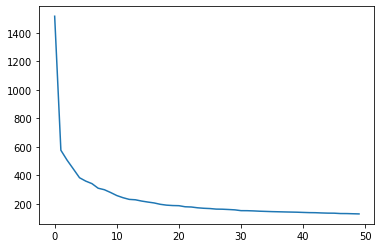

In [99]:
pd.Series(svd_params[1]).plot();

In [100]:
def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

In [101]:
svd_scores = svd_model_scoring(svd_params, testset_valid, data_description)

#### compute scores = number of test users X number of total items in training data set

In [102]:
svd_scores.shape

(750, 3652)

#### reduce predicted score for the seen item

In [103]:
downvote_seen_items(svd_scores, testset_valid, data_description)

In [104]:
svd_recs = topn_recommendations(svd_scores, topn=10)
model_evaluate(svd_recs, holdout_valid, data_description)

(0.052, 0.015026984126984125, 0.15580503833515882)

### 1 metric = hit rate (this percent with proper recoms, more or less good 10, top score 15-20), 2 = MRR, 3 = coverage (measure of diversity of recomandations, if low => model generates something popular => useless for the user, we want our recomendations to be diverce = how many unique recoms made on test users/total number of items in catalog, popularity 5%)

# Sequential TF

In [44]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    positions = 'pos',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    n_pos = n_pos
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'positions': 'pos',
 'n_users': 4831,
 'n_items': 3635,
 'n_pos': 200}

### computing tucker docmositions

In [152]:
def seqtf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["items"]
    positions = data_description["positions"]

    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    max_pos = data_description["n_pos"]
    shape = (n_users, n_items, max_pos)

    #positional attention
    attention_matrix = form_attention_matrix(
        size = data_description["n_pos"],
        exponential_decay = config["exponential_decay"],
        #rule = linear decay
        decay_factor = config["attention_decay"],
        format = 'csr'
    )

    # popularity based weighting - to 
    # combat with low diversity rating
    # reweight values in tensors - not binary
    # inversely proportional to the popularity of items
    # more sensitive to less popular items
    # promote less popular items in recoms
    
    # POpularity based scaling
    item_popularity = (
        data[itemid]
        .value_counts(sort=False)
        .reindex(range(n_items))
        .fillna(1)
        .values
    )
    
    scaling_weights = get_scaling_weights(item_popularity, scaling=config["scaling"])
    idx = data[[userid, itemid, positions]].values
    val = np.ones(idx.shape[0], dtype='f8')

    user_factors, item_factors, feedback_factors = sa_hooi(
        # hooi takes into account information about initial tensor
        idx, val, shape, config["mlrank"],
        # attention matrix
        attention_matrix = attention_matrix,
        # popularity scaling
        scaling_weights = scaling_weights,
        max_iters = config["num_iters"],
        parallel_ttm = False,
        
        # randomized svd instead of standart
        randomized = config["randomized"],
        growth_tol = config["growth_tol"],
        seed = config["seed"],
        # max hit rate is goal but here we minimize squred error, so idea
        # compute hit rate after each iteration, and if subsequent iterations 
        # do not improve hit rate we stop
        
        # typically for hit rate requires lower iterations
        iter_callback = config["iter_callback"],
    )
    return user_factors, item_factors, feedback_factors, attention_matrix


In [153]:
config = {
    #popularity scaling. 1 is factorization without any reweighting
    # (no reweighting)
    "scaling": 1,
    
    #multilinear rank is smaller tnan 50 that is used for svd
    "mlrank": (30, 30, 5),
    "n_pos": n_pos,
    "num_iters": 20,
    "attention_decay": 1,
    "randomized": True,
    "growth_tol": 1e-4,
    "seed": 42,
    "iter_callback":None,
    "exponential_decay":False
}

In [130]:
tf_params = seqtf_model_build(config, training_data, data_description)

growth of the core: 1.0
growth of the core: 0.3745644218063655
growth of the core: 0.029937756743187965
growth of the core: 0.002720934278591913
growth of the core: 0.0009144049581332012
growth of the core: 0.000530574107546262
growth of the core: 0.00019318976499166433
growth of the core: -0.00031120159025131906
Core is no longer growing. Norm of the core: 43.15271170951625.


In [114]:
def tf_scoring(params, data, data_description):
    user_factors, item_factors, pos_factors, attention_matrix = params
    last_position_projector = generate_position_projector(attention_matrix, pos_factors)

    userid = data_description["users"]
    itemid = data_description["items"]
    posid = data_description["positions"]

    test_data = data.sort_values([userid, posid])
    useridx = test_data[userid].values
    itemidx = test_data[itemid].values
    indptr, = np.where(np.diff(useridx, prepend=0, append=1))
    scores = user_scoring(indptr, itemidx, item_factors, last_position_projector)
    return scores

def user_scoring(indptr, indices, item_factors, last_position_projector):
    sequences = np.array_split(indices, indptr[1:-1])
    n_items = item_factors.shape[0]
    scores = np.zeros((len(sequences), n_items))
    for u, seq in enumerate(sequences):
        scores[u] = sequences_score(seq, item_factors, last_position_projector)
    return scores

def sequences_score(seq, item_factors, last_position_projector):
    n_pos = len(last_position_projector)
    user_profile = item_factors[seq[-(n_pos-1):], :]
    n_items = user_profile.shape[0]
    
    # scores calculation from the slide
    scores = item_factors @ (user_profile.T @ last_position_projector[-(n_items+1):-1])
    return scores

In [115]:
tf_scores = tf_scoring(tf_params, testset_valid, data_description)

/Users/sergeypetrakov/opt/miniconda3/lib/python3.8/site-packages/scipy/sparse/coo.py:431: SparseEfficiencyWarning: Constructing a DIA matrix with 200 diagonals is inefficient
  warn("Constructing a DIA matrix with %d diagonals "


In [116]:
tf_scores.shape

(750, 3652)

In [117]:
downvote_seen_items(tf_scores, testset_valid, data_description)

In [118]:
tf_recs = topn_recommendations(tf_scores, topn=10)
model_evaluate(tf_recs, holdout_valid, data_description)

(0.05466666666666667, 0.01662962962962963, 0.14649507119386637)

# Addition experiment

## different scalings

In [132]:
scalings = [-1, 0 , 1, 2, 3]
results_for_scaling = []

for scaling in scalings:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": scaling,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": 1,
        "randomized": True,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":False
    }
    
    print("#"*20)
    print("scaling = {}".format(scaling))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_for_scaling.append((hit_rate, mrr, coverage))

####################
scaling = -1
####################
growth of the core: 1.0
growth of the core: 0.47969603222098706
growth of the core: 0.1417762393296807
growth of the core: 0.15897961766090787
growth of the core: 0.11406885179974621
growth of the core: -0.02715079776549588
Core is no longer growing. Norm of the core: 0.8593823994456214.
hit_rate = 0.0427, mrr = 0.0119, coverage = 0.1574
####################
scaling = 0
####################
growth of the core: 1.0
growth of the core: 0.4224162682046584
growth of the core: 0.03474010649985927
growth of the core: 0.003111010558883804
growth of the core: 0.00042421143679460376
growth of the core: -2.8014409912421064e-05
Core is no longer growing. Norm of the core: 2.072205001554524.
hit_rate = 0.0533, mrr = 0.0164, coverage = 0.1635
####################
scaling = 1
####################
growth of the core: 1.0
growth of the core: 0.3745644218063655
growth of the core: 0.029937756743187965
growth of the core: 0.002720934278591913
growth

In [154]:
scalings = [-1, 0 , 1, 2, 3]
results_for_scaling = []

for scaling in scalings:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": scaling,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": 1,
        "randomized": True,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":False
    }
    
    print("#"*20)
    print("scaling = {}".format(scaling))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_for_scaling.append((hit_rate, mrr, coverage))

####################
scaling = -1
####################
growth of the core: 1.0
growth of the core: 0.47969603222098706
growth of the core: 0.1417762393296807
growth of the core: 0.15897961766090787
growth of the core: 0.11406885179974621
growth of the core: -0.02715079776549588
Core is no longer growing. Norm of the core: 0.8593823994456214.
hit_rate = 0.0427, mrr = 0.0119, coverage = 0.1574
####################
scaling = 0
####################


/Users/sergeypetrakov/opt/miniconda3/lib/python3.8/site-packages/scipy/sparse/coo.py:431: SparseEfficiencyWarning: Constructing a DIA matrix with 200 diagonals is inefficient
  warn("Constructing a DIA matrix with %d diagonals "


growth of the core: 1.0
growth of the core: 0.4224162682046584
growth of the core: 0.03474010649985927
growth of the core: 0.003111010558883804
growth of the core: 0.00042421143679460376
growth of the core: -2.8014409912421064e-05
Core is no longer growing. Norm of the core: 2.072205001554524.
hit_rate = 0.0533, mrr = 0.0164, coverage = 0.1635
####################
scaling = 1
####################
growth of the core: 1.0
growth of the core: 0.3745644218063655
growth of the core: 0.029937756743187965
growth of the core: 0.002720934278591913
growth of the core: 0.0009144049581332012
growth of the core: 0.000530574107546262
growth of the core: 0.00019318976499166433
growth of the core: -0.00031120159025131906
Core is no longer growing. Norm of the core: 43.15271170951625.
hit_rate = 0.0547, mrr = 0.0166, coverage = 0.1465
####################
scaling = 2
####################
growth of the core: 1.0
growth of the core: 0.3510399833293909
growth of the core: 0.03284602816198237
growth of the

In [155]:
svd_random_inits = [True, False]
results_svd_init = []

for svd_random_init in svd_random_inits:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": 1.0,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": 1,
        "randomized": svd_random_init,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":False
    }
    
    print("#"*20)
    print("svd_random_init = {}".format(svd_random_init))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_svd_init.append((hit_rate, mrr, coverage))

####################
svd_random_init = True
####################
growth of the core: 1.0
growth of the core: 0.3745644218063655
growth of the core: 0.029937756743187965
growth of the core: 0.002720934278591913
growth of the core: 0.0009144049581332012
growth of the core: 0.000530574107546262
growth of the core: 0.00019318976499166433
growth of the core: -0.00031120159025131906
Core is no longer growing. Norm of the core: 43.15271170951625.
hit_rate = 0.0547, mrr = 0.0166, coverage = 0.1465
####################
svd_random_init = False
####################
growth of the core: 1.0
growth of the core: 0.37471558308257263
growth of the core: 0.02931286136012277
growth of the core: 0.0031538908794840914
growth of the core: 0.0009751508873759329
growth of the core: 0.00029955015941700807
growth of the core: 3.727518808117806e-05
Core is no longer growing. Norm of the core: 43.1534290709896.
hit_rate = 0.0547, mrr = 0.0161, coverage = 0.147


In [181]:
attention_decays_linear = [0.01, 0.1, 1, 2, 5, 10]
results_linear_decay = []

for attention_decay in attention_decays_linear:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": 1.0,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": attention_decay,
        "randomized": svd_random_init,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":False
    }
    
    print("#"*20)
    print("Linear decay with attention = {}".format(attention_decay))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_linear_decay.append((hit_rate, mrr, coverage))

####################
Linear decay with attention = 0.01
####################
growth of the core: 1.0
growth of the core: 0.2672544003336291
growth of the core: 0.026723099823996697
growth of the core: 0.00706782439948392
growth of the core: 0.00264011007898132
growth of the core: 0.0011689573272384301
growth of the core: 0.0005775948931953247
growth of the core: 0.00032147830488982095
growth of the core: 0.00020136645474647067
growth of the core: 0.00013754239209982713
growth of the core: 9.838096933248811e-05
Core is no longer growing. Norm of the core: 37.34572644026385.
hit_rate = 0.0507, mrr = 0.0159, coverage = 0.1481
####################
Linear decay with attention = 0.1
####################
growth of the core: 1.0
growth of the core: 0.27934837353171027
growth of the core: 0.017356555448977032
growth of the core: 0.0039044124760133506
growth of the core: 0.0018037882878430367
growth of the core: 0.0008624937969685271
growth of the core: 0.0004556678567788813
growth of the core: 

In [183]:
attention_decays_exp = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10]
results_exp_decay = []

for attention_decay in attention_decays_exp:
    config = {
        #popularity scaling. 1 is factorization without any reweighting
        # (no reweighting)
        "scaling": 1.0,

        #multilinear rank is smaller tnan 50 that is used for svd
        "mlrank": (30, 30, 5),
        "n_pos": n_pos,
        "num_iters": 20,
        "attention_decay": attention_decay,
        "randomized": svd_random_init,
        "growth_tol": 1e-4,
        "seed": 42,
        "iter_callback":None,
        "exponential_decay":True
    }
    
    print("#"*20)
    print("Exponential decay with attention = {}".format(attention_decay))
    print("#"*20)
    tf_params = seqtf_model_build(config, training_data, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hit_rate, mrr, coverage = np.round(model_evaluate(tf_recs, holdout_valid, data_description), 4)
    print("hit_rate = {}, mrr = {}, coverage = {}".format(hit_rate, mrr, coverage))
    results_exp_decay.append((hit_rate, mrr, coverage))

####################
Exponential decay with attention = 0.0001
####################
growth of the core: 1.0
growth of the core: 0.2670350915934578
growth of the core: 0.02691385084095853
growth of the core: 0.007122611280289261
growth of the core: 0.002659558220052235
growth of the core: 0.0011779165689092912
growth of the core: 0.0005818771127776927
growth of the core: 0.00032346815980841535
growth of the core: 0.00020225847994472722
growth of the core: 0.0001379080485096497
growth of the core: 9.848916023167341e-05
Core is no longer growing. Norm of the core: 37.346573900513.
hit_rate = 0.0493, mrr = 0.0157, coverage = 0.147
####################
Exponential decay with attention = 0.001
####################
growth of the core: 1.0
growth of the core: 0.2759720094015907
growth of the core: 0.020068819525994742
growth of the core: 0.004943591831014345
growth of the core: 0.0020076592828185843
growth of the core: 0.0009037388614631818
growth of the core: 0.0004647592749098964
growth of t

## Quality metrics and exponential decay

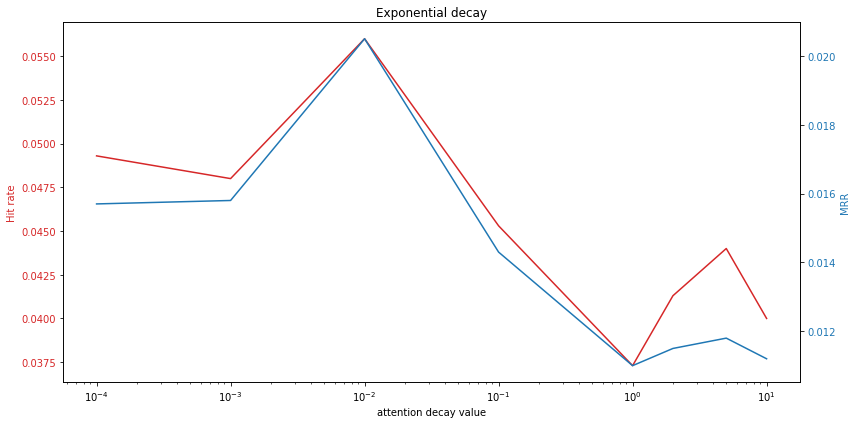

In [206]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Exponential decay")
color = 'tab:red'
ax1.set_xlabel('attention decay value')
ax1.set_ylabel('Hit rate', color=color)
ax1.set_xscale("log")
ax1.plot(attention_decays_exp, np.array(results_exp_decay)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MRR', color=color)  # we already handled the x-label with ax1
ax2.plot(attention_decays_exp, np.array(results_exp_decay)[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale("log")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

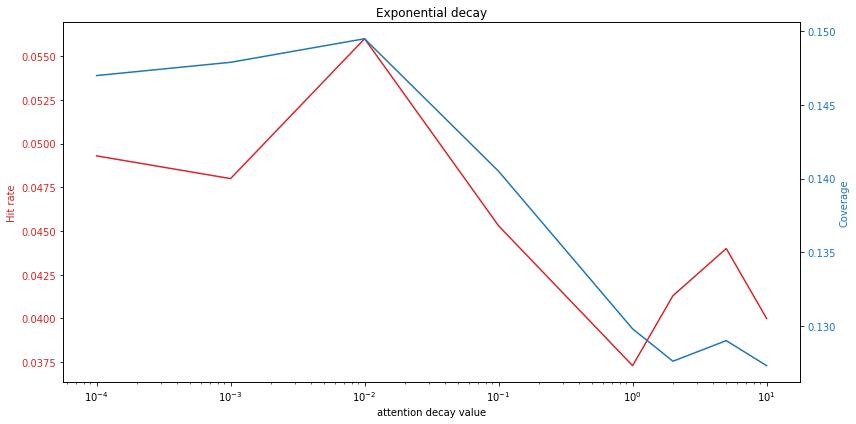

In [207]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Exponential decay")
color = 'tab:red'
ax1.set_xlabel('attention decay value')
ax1.set_ylabel('Hit rate', color=color)
ax1.set_xscale("log")
ax1.plot(attention_decays_exp, np.array(results_exp_decay)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Coverage', color=color)  # we already handled the x-label with ax1
ax2.plot(attention_decays_exp, np.array(results_exp_decay)[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale("log")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Quality metrics and linear decay

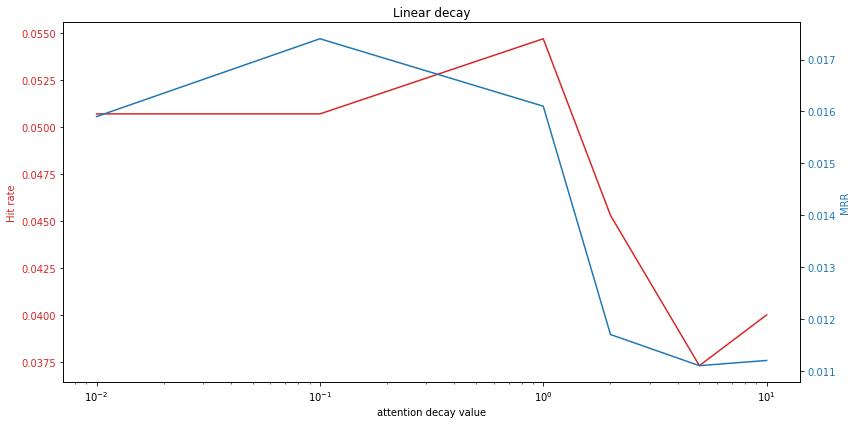

In [204]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Linear decay")
color = 'tab:red'
ax1.set_xlabel('attention decay value')
ax1.set_ylabel('Hit rate', color=color)
ax1.set_xscale("log")
ax1.plot(attention_decays_linear, np.array(results_linear_decay)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MRR', color=color)  # we already handled the x-label with ax1
ax2.plot(attention_decays_linear, np.array(results_linear_decay)[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale("log")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

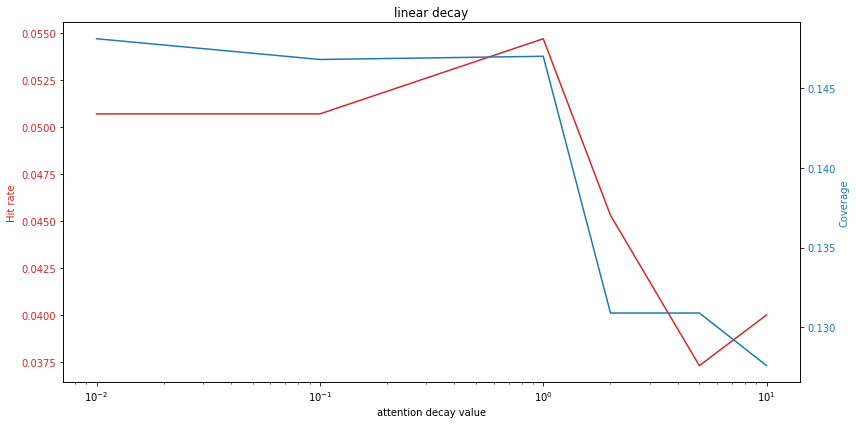

In [205]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("linear decay")
color = 'tab:red'
ax1.set_xlabel('attention decay value')
ax1.set_ylabel('Hit rate', color=color)
ax1.set_xscale("log")
ax1.plot(attention_decays_linear, np.array(results_linear_decay)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Coverage', color=color)  # we already handled the x-label with ax1
ax2.plot(attention_decays_linear, np.array(results_linear_decay)[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale("log")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## SVD random initialization. difference in terms of metrics

In [219]:
(np.array(results_svd_init)[0,:] - np.array(results_svd_init)[1,:]) / np.array(results_svd_init)[0,:] *100

array([ 0.        ,  3.01204819, -0.34129693])

# Scalings

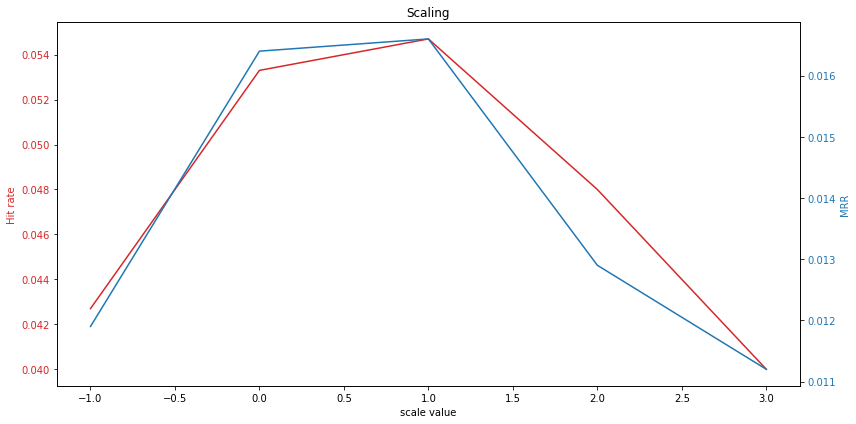

In [236]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Scaling")
color = 'tab:red'
ax1.set_xlabel('scale value')
ax1.set_ylabel('Hit rate', color=color)

ax1.plot(scalings, np.array(results_for_scaling)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('MRR', color=color)  # we already handled the x-label with ax1
ax2.plot(scalings, np.array(results_for_scaling)[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

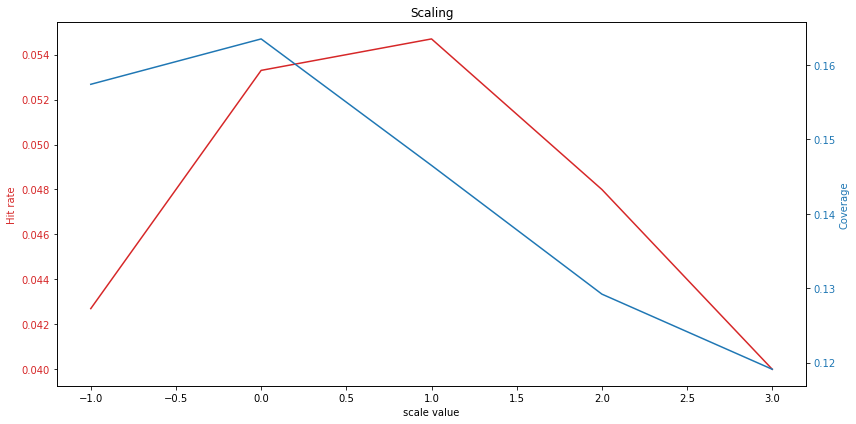

In [238]:
fig, ax1 = plt.subplots(figsize = (12,6))
plt.title("Scaling")
color = 'tab:red'
ax1.set_xlabel('scale value')
ax1.set_ylabel('Hit rate', color=color)

ax1.plot(scalings, np.array(results_for_scaling)[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Coverage', color=color)  # we already handled the x-label with ax1
ax2.plot(scalings, np.array(results_for_scaling)[:,2], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()